In [1]:
import sqlite3

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import geomtools as geo

In [3]:
# Lecture des zones parents :

db_filename = '../data/arbres.db'
db = sqlite3.connect(db_filename)

cursor = db.cursor()

In [4]:
# get dict of all the zones
cursor.execute(""" SELECT DISTINCT code_parent, code_parent_desc FROM arbres  """)
zones_parent = { x[0]: {'name':x[1]} for x in cursor.fetchall() }

print( len(zones_parent) )

1445


In [5]:
# add infos about trees
for code_parent, infos in zones_parent.items():
    cursor.execute("""
        SELECT genre_bota, longitude, latitude FROM arbres 
        WHERE code_parent  = ?""", (code_parent, ))

    #nametuples = cursor.fetchmany(10)
    infos['arbres'] = cursor.fetchall()

In [6]:
def get_species( arbres ):
    """ retourne la liste des espèces (genre) présentes
    """
    spec = { tree[0] for tree in arbres }
    return list(spec)

In [7]:
import geojson as gj

def convert_to_geojson( polytype, coords  ):
    """ Format coords in the geoJson format (dict)
        peut être un simple ou MultiPolygon
        
        :param polytype: 'MultiPolygon'  or   'Polygon'  
        :coords: list of lists
        :return: dict
    """
    
    if polytype == 'MultiPolygon':
        geom = gj.MultiPolygon( coords )

    elif polytype == 'Polygon':
        geom = gj.Polygon( coords )
        
    return geom

In [8]:
# - loop -
iter_limit = 200
featurelist = []
for index, (code_parent, infos) in zip( range(iter_limit), zones_parent.items()):

    points_deg = [ (tree[1], tree[2])  for tree in infos['arbres'] ]
    points_m, scale_back = geo.get_coordsarray( points_deg )

    added_points = geo.add_contourpoints( points_m, n_points = 5, r_cercle = 3 )

    all_points = np.concatenate( (added_points, points_m) )

    Rcritic = 12  # meter
    polygon = geo.alpha_shape( all_points, Rcritic  )[0]

    polytype, polycoords = geo.get_polycoords( polygon, scale_back )
    geom = convert_to_geojson( polytype, polycoords )
    featprops = {'code_parent':code_parent , 'code_parent_desc':infos['name'],
                 'genre':get_species(infos['arbres']), 
                 'numberoftrees':len(infos['arbres'])}

    feat = gj.Feature(geometry=geom, properties=featprops ) 
    featurelist.append( feat )
    
    print( index, end='\r' )
    
print(len(featurelist))

200


In [10]:
# - save -
feature_collection = gj.FeatureCollection( featurelist )

jsontext = gj.dumps(feature_collection)

with open('../data/zoneparents.geojson', '+w') as file:
    file.write( jsontext )

## Debug zone

In [7]:
# Pick one :
code_parent, infos = list( zones_parent.items() )[187]
print( infos['name'], len(infos['arbres']), get_species(infos['arbres'])  )

R Corot 6 ['Platanus']


In [8]:
points_deg = [ (tree[1], tree[2])  for tree in infos['arbres'] ]
points_m, scale_back = geo.get_coordsarray( points_deg )

added_points = geo.add_contourpoints( points_m, n_points = 5, r_cercle = 3 )

# - Alpha hub - 
all_points = np.concatenate( (added_points, points_m) )

Rcritic = 12  # m
polygon = geo.alpha_shape( all_points, Rcritic  )[0]

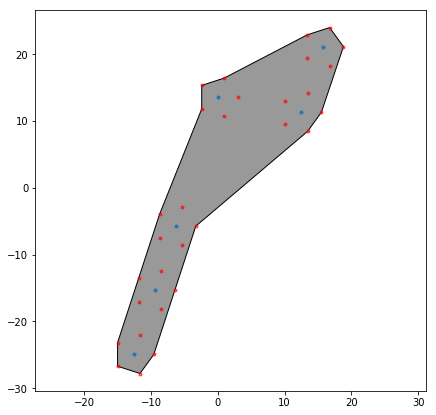

In [20]:
# plot
geo.plot_polygon( polygon  )
plt.plot( *points_m.T, '.' )
plt.plot( *added_points.T, '.r', alpha=.6 )

plt.axis('equal');

In [21]:
polytype, polycoords = geo.get_polycoords( polygon, scale_back )
geom = convert_to_geojson( polytype, polycoords )
featprops = {'code_parent':code_parent , 'code_parent_desc':infos['name'], 'genre':get_species(infos['arbres']), 
            'numberoftrees':len(infos['arbres'])}
feat = gj.Feature(geometry=geom, properties=featprops ) 

In [18]:
feat

{"geometry": {"coordinates": [[5.71003359857037, 45.16809400121101], [5.71000343444458, 45.1681038021296], [5.71000343444458, 45.1681355185684], [5.71003174479774, 45.1682220651412], [5.71005991585443, 45.1683081835002], [5.71011669011149, 45.1684500059687], [5.71011669011149, 45.1684817224075], [5.71014685423728, 45.16849152332609], [5.71025861092004, 45.1685497379054], [5.71028877504583, 45.16855953882399], [5.710307417500809, 45.168533879686], [5.710277724836719, 45.168445455166], [5.71025908238174, 45.16841979602801], [5.710108722435199, 45.1682923252808], [5.710080551378509, 45.1682062069218], [5.710052241025349, 45.168119660349], [5.71003359857037, 45.16809400121101]], "type": "Polygon"}, "properties": {"code_parent": "ESP1231", "code_parent_desc": "R Corot", "genre": ["Platanus"], "numberoftrees": 6}, "type": "Feature"}

In [22]:
geom

{"coordinates": [[5.71003359857037, 45.16809400121101], [5.71000343444458, 45.1681038021296], [5.71000343444458, 45.1681355185684], [5.71003174479774, 45.1682220651412], [5.71005991585443, 45.1683081835002], [5.71011669011149, 45.1684500059687], [5.71011669011149, 45.1684817224075], [5.71014685423728, 45.16849152332609], [5.71025861092004, 45.1685497379054], [5.71028877504583, 45.16855953882399], [5.710307417500809, 45.168533879686], [5.710277724836719, 45.168445455166], [5.71025908238174, 45.16841979602801], [5.710108722435199, 45.1682923252808], [5.710080551378509, 45.1682062069218], [5.710052241025349, 45.168119660349], [5.71003359857037, 45.16809400121101]], "type": "Polygon"}